# MBHB search runs
## FMT Data Analysis Robustness Report

Notebook to generate data for MBHB search runs for the FMT DARR report.

E Castelli - 2023

## 0. Settings and package import

In [1]:
# Python standard packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy.signal
from scipy.stats import norm
import h5py
import time

In [2]:
# Custom LISA Data Analysis packages 
from ldc.lisa.noise import get_noise_model
from ldc.common import tools
from ldc.common.constants import ldc_cosmo as cosmo
from ldc.common.series import TimeSeries, FrequencySeries, TDI
from ldc.common.tools import compute_tdi_snr, window
from ldc.lisa.orbits import Orbits
from ldc.lisa.projection import ProjectedStrain
from ldc.lisa.noise import AnalyticNoise, get_noise_model
from ldc.waveform.lisabeta import FastBHB

import lisabeta.lisa.ldcnoise as ldcnoise
from bayesdawn import datamodel, psdmodel
import lisaorbits

MLDC modules could not be loaded.


## 1. LDC 2b *Spritz* MBHB-1

Download LDC 2b *Spritz* MBHB-1 data from the LDC official website (https://lisa-ldc.lal.in2p3.fr/challenge2b) and save them to the `./data/` folder.

In [3]:
# import data
fname = '../data/LDC2_spritz_mbhb1_training_v2.h5'
# open file with h5py
fid = h5py.File(fname)
# print all dataset attributes
# fid.visititems(print_attrs)
cfg = dict(zip(fid["obs/config"].keys(), [v[()] for v in fid["obs/config"].values()]))

In [4]:
parstr = ''
for param, val in zip(fid['sky/cat'].attrs.keys(),fid['sky/cat'][()]):
    parstr += str(param)+'='+str(val)+'\t'
    
print(parstr)

CoalescenceTime=-0.30300442294174235	Distance=1.2925183861048521	EclipticLatitude=1.2031361791056812	EclipticLongitude=2.097303543065685	Inclination=0.747377	InitialAzimuthalAngleL=0.8388	InitialPolarAngleL=1323277.47932	Mass1=612485.5060299999	Mass2=11526944.921879262	PhaseAtCoalescence=1.2201968860015653	PolarAngleOfSpin1=2.6919824500032945	PolarAngleOfSpin2=1.808398497592109	Polarization=1.73941	Redshift=13470.983558972537	Spin1=31558149.763545603	Spin2=3.0	


### 1.1. Import the Spritz `tdi` datasets

The Spritz HDF5 file is structured in various groups:
- group `obs` containing `noise + signal + artifacts` (gaps + glitches)
- group `clean` containing `noise + signal`
- group `sky` containing `signal`
- group `noisefree` containing `signal + artifacts` (gaps + glitches)
- group `gal` containing `galaxy confusion background`

Each of these groups hosts a dataset `tdi` that contains TDI combinations $X$, $Y$ and $Z$.

The import function `load_tdi_timeseries` also builds the missing TDI dataset:
- TDI dataset `noise` containing `noise`
- TDI dataset `glitch` containing `glitches`
- TDI dataset `noiseglitch` containing `noise + glitches`
- TDI dataset `clean_gapped` containing `noise + signal + gaps`
- TDI dataset `noise_gapped` containing `noise + gaps`
- TDI dataset `sky_gapped` containing `signal + gaps`
- TDI dataset `noise` containing `noise + glitches + gaps`

In [5]:
from bayesdawn.connect.fillgaps import load_tdi_timeseries

In [6]:
xyzdata = load_tdi_timeseries(fname = fname)

In [7]:
# set up dataset constant values

skip = 0 # number of samples to skip
ndata = len(xyzdata['obs'][:]) # length of dataset
dt = xyzdata['obs']['t'][1]-xyzdata['obs']['t'][0] # time step
tobs = ndata * dt # observation time
fs = 1.0/dt # sampling frequency
fmin = np.round(1.0/(tobs),9)+2e-9 # minumum frequency


print('skip','ndata','dt', 'fs', 'tobs\t', 'fmin', sep='\t',end='\n'+60*'-'+'\n')
print(skip, ndata, dt, fs, tobs, fmin, sep='\t')

skip	ndata	dt	fs	tobs		fmin
------------------------------------------------------------
0	535680	5.0	0.2	2678400.0	3.75e-07


In [8]:
from bayesdawn.connect.fillgaps import build_orthogonal_tdi, generate_freq_data

### 1.2 Clean MBHB signal + noise

The desired dataset for this is `'clean'`. Note that this dataset does not contain galactic confusion noise, included in dataset `gal`.

Let's generate the orthogonal $A, E, T$ time series for this dataset using function `build_orthogonal_tdi`.

In [9]:
aetdata = build_orthogonal_tdi(xyzdata, skip = skip) # skip 0 samples at the beginning of the dataset

Function `generate_freq_data` evaluated fft and psd of data in the format used by John for the MBHB search: 

`aetfft` is an ordered ndarray with structure:

    [f, fftA.real, fftA.imag, fftE.real, fftE.imag, fftT.real, fftT.imag]
    
`aetpsd` is an ordered ndarray with structure:

    [f, psdA, psdE, psdT]

In [10]:
from bayesdawn.connect.fillgaps import plot_compare_spectra_timeseries

/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/numpy/lib/histograms.py:905: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


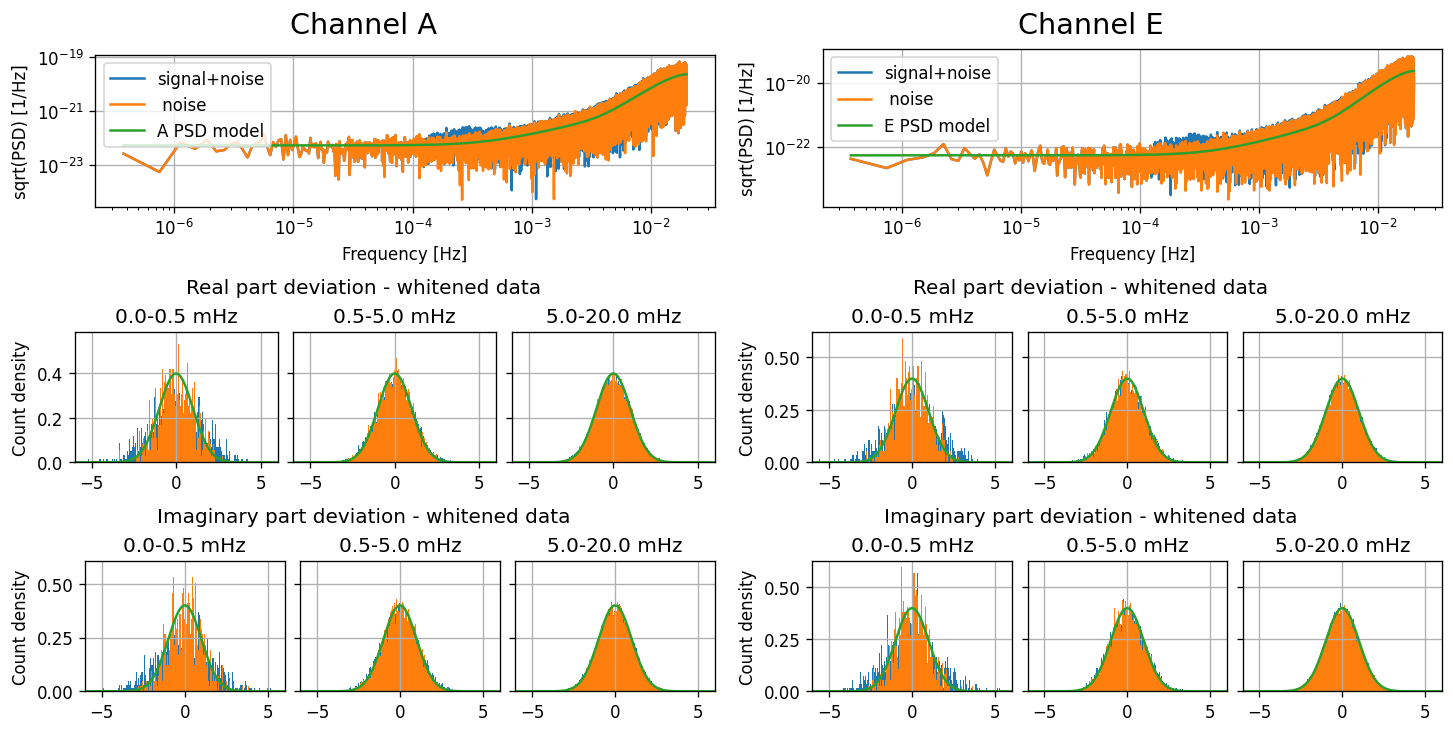

In [11]:
plot_compare_spectra_timeseries(data = [aetdata['clean'], aetdata['noise']] ,
                                freq_bands=[5e-4, 5e-3],
                                fmin = fmin,
                                fmax = 2e-2,
                               labels = ['signal+noise', ' noise'], 
                                save = False)

In [12]:
aetfft, aetpsd, _ = generate_freq_data(aetdata['clean'], # data 
                                       split = True, # flag to generate data in the [f, fftA.real, fftA.imag, fftE.real, fftE.imag, fftT.real, fftT.imag] format
                                       fmin = fmin, # miminum PSD evaluation frequency
                                       win='boxcar')  # window to be applied to the data when evualting the PSD

/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/bayesdawn-0.1.0-py3.10.egg/bayesdawn/connect/fillgaps.py:492: ComplexWarning: Casting complex values to real discards the imaginary part


In [13]:
# save fft data 
datadir = '../data/'
fileroot = 'LDC_mbhb1_aetdata_'
np.savetxt(datadir+fileroot+'clean.txt', aetfft, 
           fmt = ['%.5e']+6*['%.18e'],
           header = ''' LDC MBHB-1 dataset. MBHB signal + LISA noise.
           MBHB parameters:
           {params}
           
           f \t ReA \t ImA \t ReE \t ImE \t ReT \t ImT'''.format(params=parstr))

### 1.3 MBHB data + noise + unmitigated glitches

The desired dataset for this is `'cleanglitch'`.

Let's generate the orthogonal $A, E, T$ time series for this dataset using function `build_orthogonal_tdi`.

In [14]:
aetglitch = build_orthogonal_tdi(xyzdata, skip = skip)

Function `generate_freq_data` evaluated fft and psd of data in the format used by John for the MBHB search: 

`aetglitchfft` is an ordered ndarray with structure:

    [f, fftA.real, fftA.imag, fftE.real, fftE.imag, fftT.real, fftT.imag]
    
`aetglitchpsd` is an ordered ndarray with structure:

    [f, psdA, psdE, psdT]

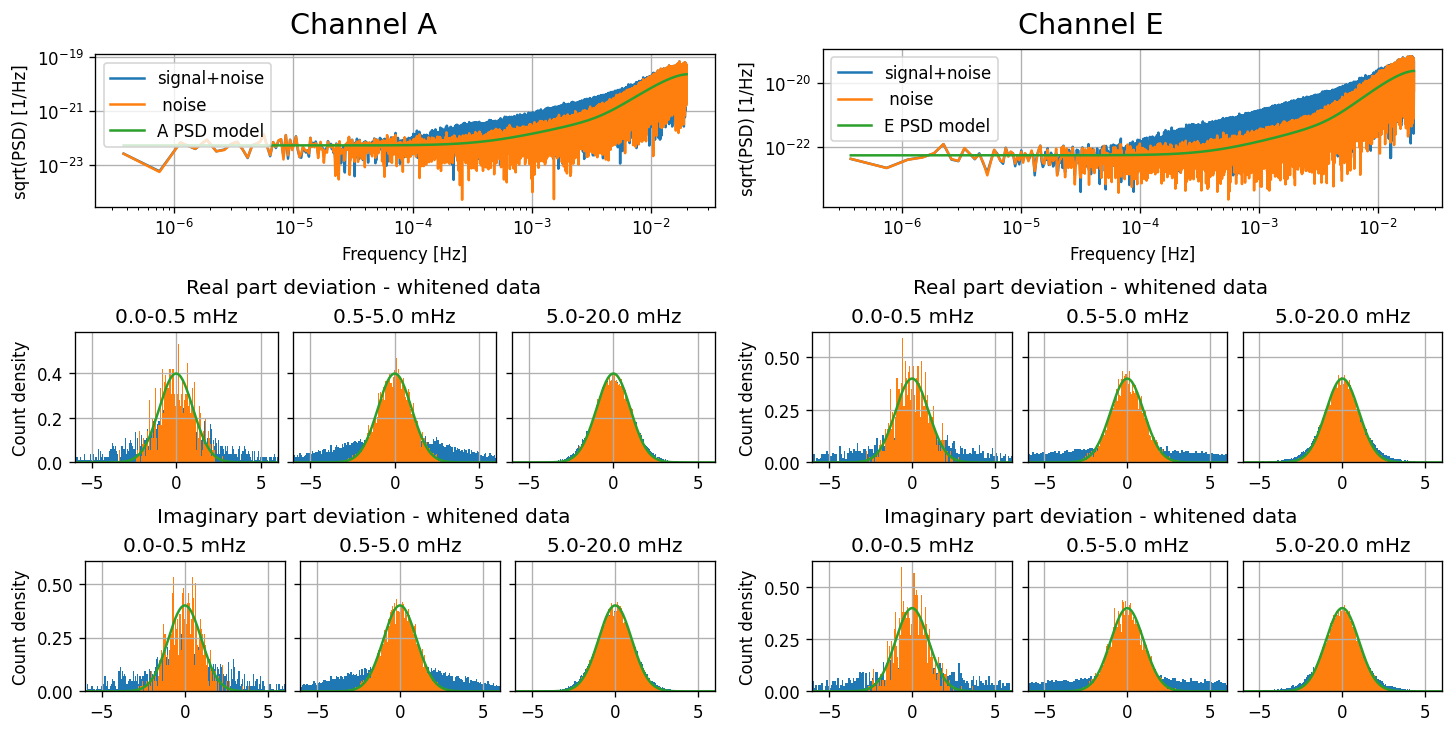

In [15]:
plot_compare_spectra_timeseries(data = [aetglitch['cleanglitch'], aetglitch['noise']] ,
                                freq_bands=[5e-4, 5e-3],
                                fmin = fmin,
                                fmax = 2e-2,
                               labels = ['signal+noise', ' noise'], 
                                save = False)

In [16]:
aetglitchfft, aetglitchpsd, _ = generate_freq_data(aetglitch['cleanglitch'], 
                                       split = True, 
                                       fmin = fmin,
                                       win='boxcar')

In [17]:
# save fft data 
datadir = '../data/'
fileroot = 'LDC_mbhb1_aetdata_'
np.savetxt(datadir+fileroot+'glitch.txt', aetglitchfft, 
           fmt = ['%.5e']+6*['%.18e'],
           header = ''' LDC MBHB-1 dataset. MBHB signal + LISA noise.
           MBHB parameters:
           {params}
           
           f \t ReA \t ImA \t ReE \t ImE \t ReT \t ImT'''.format(params=parstr))

### 1.4 MBHB data + noise + unmitigated glitches + unmitigated gaps

The desired dataset for this is `'obs'`. Pay attention to the fact that `'obs'` contains the galactic confusion noise contribution `'gal'`.

Let's generate the orthogonal $A, E, T$ time series for this dataset using function `build_orthogonal_tdi`.

In [18]:
aetobs = build_orthogonal_tdi(xyzdata, skip = skip)

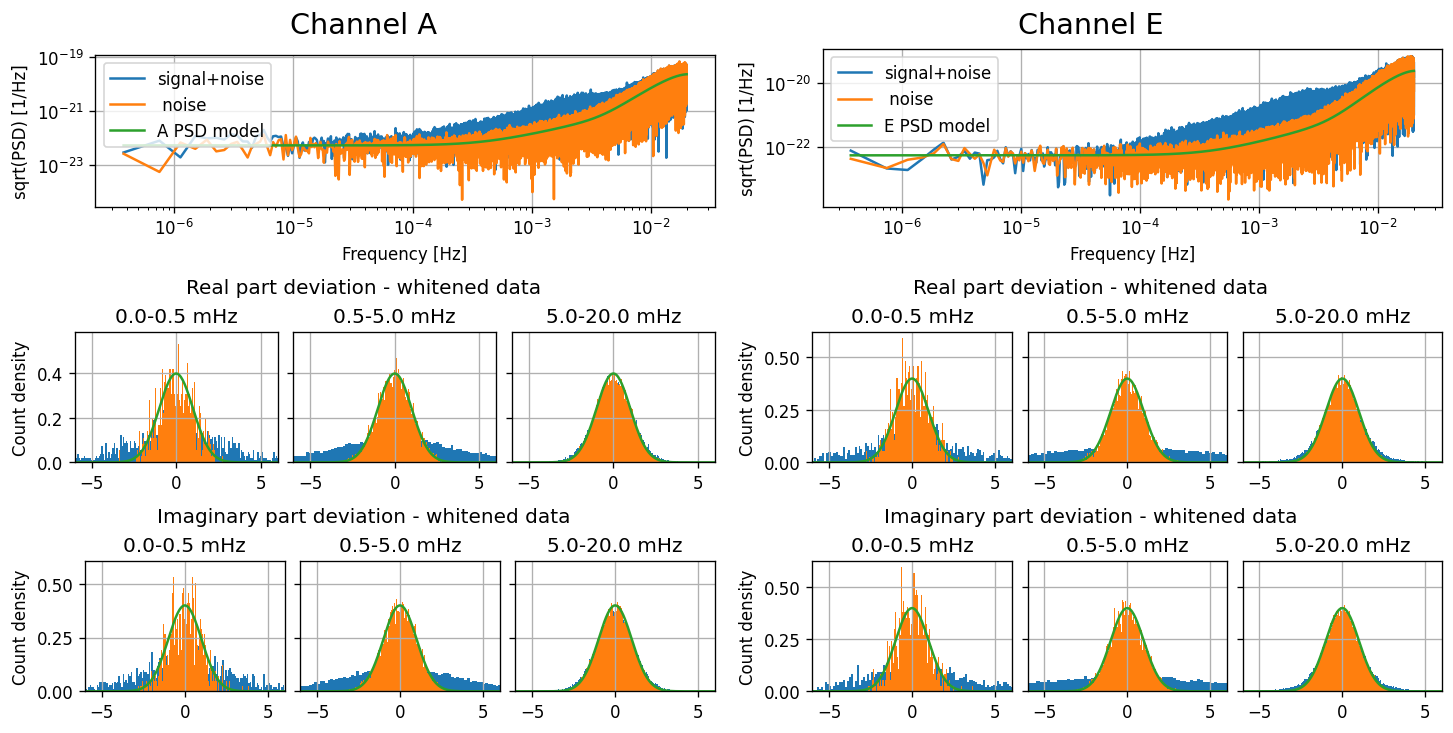

In [19]:
plot_compare_spectra_timeseries(data = [aetobs['obs'], aetobs['noise']] ,
                                freq_bands=[5e-4, 5e-3],
                                fmin = fmin,
                                fmax = 2e-2,
                               labels = ['signal+noise', ' noise'], 
                                save = False)

Function `generate_freq_data` evaluated fft and psd of data in the format used by John for the MBHB search: 

`aetobsfft` is an ordered ndarray with structure:

    [f, fftA.real, fftA.imag, fftE.real, fftE.imag, fftT.real, fftT.imag]
    
`aetobspsd` is an ordered ndarray with structure:

    [f, psdA, psdE, psdT]

In [20]:
aetobsfft, aetobspsd, _ = generate_freq_data(aetobs['obs'], 
                                       split = True, 
                                       fmin = fmin,
                                       win='boxcar') # window to be applied to the data

In [21]:
# save fft data 
datadir = '../data/'
fileroot = 'LDC_mbhb1_aetdata_'
np.savetxt(datadir+fileroot+'glitch_gaps.txt', aetobsfft, 
           fmt = ['%.5e']+6*['%.18e'],
           header = ''' LDC MBHB-1 dataset. MBHB signal + LISA noise.
           MBHB parameters:
           {params}
           
           f \t ReA \t ImA \t ReE \t ImE \t ReT \t ImT'''.format(params=parstr))